# Importing Libraries


In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import gc
import os
import csv
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import timm
import torch
from torchvision import models
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split


# Setting up GPU

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
if torch.cuda.device_count() > 1:
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    model = torch.nn.DataParallel(model)
    
    

Using device: cuda:0


# Cleaning Data

- Dealing with inconsistent csv records with actual dataset present (there are more csv records than image count)

In [1]:
image_dir = r'D:\Datasets\CropDiseaseClassificationOriginal\Data\train_images'
csv_path = r'D:\Datasets\CropDiseaseClassificationOriginal\Data\train.csv'

image_files = {file for file in os.listdir(image_dir) if file.endswith(('.png', '.jpg', '.jpeg'))}
df = pd.read_csv(csv_path)
filtered_df = df[df['image_id'].isin(image_files)]
filtered_df.to_csv(csv_path, index=False)
print("CSV has been updated with relevant rows.")



In [ ]:

def split_data(source_directory, destination_directory, train_size=0.8):
    classes = os.listdir(source_directory)
    train_directory = os.path.join(destination_directory, 'train')
    test_directory = os.path.join(destination_directory, 'test')
    
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)
    
    for class_name in classes:
        class_dir = os.path.join(source_directory, class_name)
        train_class_dir = os.path.join(train_directory, class_name)
        test_class_dir = os.path.join(test_directory, class_name)
        
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        all_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        
        train_files, test_files = train_test_split(all_files, train_size=train_size, random_state=42)
        
        for file in train_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(train_class_dir, file))
        for file in test_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(test_class_dir, file))

source_dir = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\organizedData'
dest_dir = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\'

split_data(source_dir, dest_dir)


# Augmenting the images

Requirement to run this code properly: Undersample class 4 to 3000 images and copy paste the organizedData to another directory where you want the data augmented


In [ ]:
def load_images(folder_path, target_size=None):
    """ Load all images from a folder and resize them if target_size is provided. """
    images = []
    filenames = os.listdir(folder_path)
    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        with Image.open(img_path) as img:
            if target_size:
                img = img.resize(target_size, Image.Resampling.LANCZOS)
            images.append(np.array(img, dtype=np.float32))
    return images, filenames

def augment_images(data_gen, images, labels, batch_size, save_path, prefix, target_count):
    """ Augment images and save them to a directory, stopping when the target count is reached. """
    generator = data_gen.flow(images, labels, batch_size=batch_size, save_to_dir=save_path, save_prefix=prefix, save_format='jpeg')
    current_count = len(images)  
    for i, (img_batch, label_batch) in enumerate(generator):
        current_count += len(img_batch)  
        if current_count >= target_count:  
            print(f"Target reached with batch {i}. Total count now {current_count}.")
            break
        print(f"Batch {i} saved, {len(img_batch)} images")
        gc.collect()  

def generate_and_save_augmented_images(root_folder, save_folder, target_size=None, target_count=3000):
    data_gen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2,
        fill_mode='reflect'
    )
    label_encoder = LabelEncoder()

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        save_path = os.path.join(save_folder, folder_name)
        if not os.path.exists(save_path):
            os.makedirs(save_path)  # Ensure save directory exists
        
        images, filenames = load_images(folder_path, target_size=target_size)
        labels = [folder_name] * len(images)
        images_array = np.array(images)
        labels_array = label_encoder.fit_transform(labels)
        labels_array = to_categorical(labels_array)

        current_count = len(images)
        needed = target_count - current_count
        print(f"Processing {folder_name}, initial count: {current_count}, target: {target_count}, needed: {needed}")
        
        if needed > 0:
            batch_size = min(100, needed)
            augment_images(data_gen, images_array, labels_array, batch_size, save_path, 'aug', target_count)

root_folder = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\train'
save_folder = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDisease'

generate_and_save_augmented_images(root_folder, save_folder, target_size=(224, 224), target_count=3000)


# Labelling with csv

In [ ]:

def create_csv(base_path,output_csv_file):
    with open(output_csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image Name", "Label"])  
    
        for folder in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder)
            
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        writer.writerow([filename, folder])
                    else:
                        print(filename,folder,"CHECKING!")

train_path = "D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDisease"
train_csv = "D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDisease\\image_labels.csv"
test_path = "D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\test"
test_csv = "D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\test\\image_labels.csv"

create_csv(train_path,train_csv)
create_csv(test_path,test_csv)


# Noise Reduction and Feature Engineering


In [2]:


def apply_gaussian_blur(img):
    """Apply Gaussian Blur to a PIL image."""
    return img.filter(ImageFilter.GaussianBlur(radius=2))
    
def apply_clahe(img):
    """Apply CLAHE to a grayscale version of a PIL image and convert back to RGB."""
    img_cv = np.array(img)  
    img_gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY) 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray) 
    img_clahe_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)  
    img_pil = Image.fromarray(img_clahe_rgb) 
    return img_pil


def emphasize_yellow(img):
    """Convert image to HSV and isolate yellow hues."""
    img_hsv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    mask = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    result = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
    result = cv2.cvtColor(result, cv2.COLOR_HSV2RGB)
    return Image.fromarray(result)



# Setting up model

In [7]:
transform = transforms.Compose([
    transforms.Lambda(apply_gaussian_blur),
    #transforms.Lambda(apply_clahe),
    #transforms.Lambda(emphasize_yellow),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
model_name = 'vit_base_patch16_224' 
model = timm.create_model(model_name, pretrained=True, num_classes=5)
model.head = nn.Linear(model.head.in_features, 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
dataset_path = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDisease' 
testing_path = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\test' 
dataset = ImageFolder(root=dataset_path, transform=transform)
test_dataset = ImageFolder(root=testing_path, transform=transform)

In [7]:
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
batch_size = 16
num_workers = 0
pin_memory = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = 100 * val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/20 - Train Loss: 1.8148, Train Accuracy: 23.23%
Epoch 1/20 - Validation Loss: 1.5198, Validation Accuracy: 31.30%
Epoch 2/20 - Train Loss: 1.5675, Train Accuracy: 28.00%
Epoch 2/20 - Validation Loss: 1.5576, Validation Accuracy: 31.67%
Epoch 3/20 - Train Loss: 1.4959, Train Accuracy: 32.38%
Epoch 3/20 - Validation Loss: 1.5047, Validation Accuracy: 32.13%
Epoch 4/20 - Train Loss: 1.4871, Train Accuracy: 32.73%
Epoch 4/20 - Validation Loss: 1.4711, Validation Accuracy: 33.80%
Epoch 5/20 - Train Loss: 1.5219, Train Accuracy: 30.07%
Epoch 5/20 - Validation Loss: 1.5483, Validation Accuracy: 28.77%
Epoch 6/20 - Train Loss: 1.5074, Train Accuracy: 31.61%
Epoch 6/20 - Validation Loss: 1.4990, Validation Accuracy: 34.63%
Epoch 7/20 - Train Loss: 1.5091, Train Accuracy: 31.43%
Epoch 7/20 - Validation Loss: 1.5220, Validation Accuracy: 31.17%
Epoch 8/20 - Train Loss: 1.5136, Train Accuracy: 31.49%
Epoch 8/20 - Validation Loss: 1.5072, Validation Accuracy: 30.77%
Epoch 9/20 - Train Loss:

In [12]:
from sklearn.metrics import classification_report

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.09      0.33      0.14       221
Cassava Brown Streak Disease (CBSD)       0.13      0.01      0.02       431
         Cassava Green Mottle (CGM)       0.05      0.12      0.07       493
       Cassava Mosaic Disease (CMD)       0.87      0.66      0.75      8027
                            Healthy       0.07      0.21      0.11       466

                           accuracy                           0.58      9638
                          macro avg       0.24      0.27      0.22      9638
                       weighted avg       0.74      0.58      0.64      9638



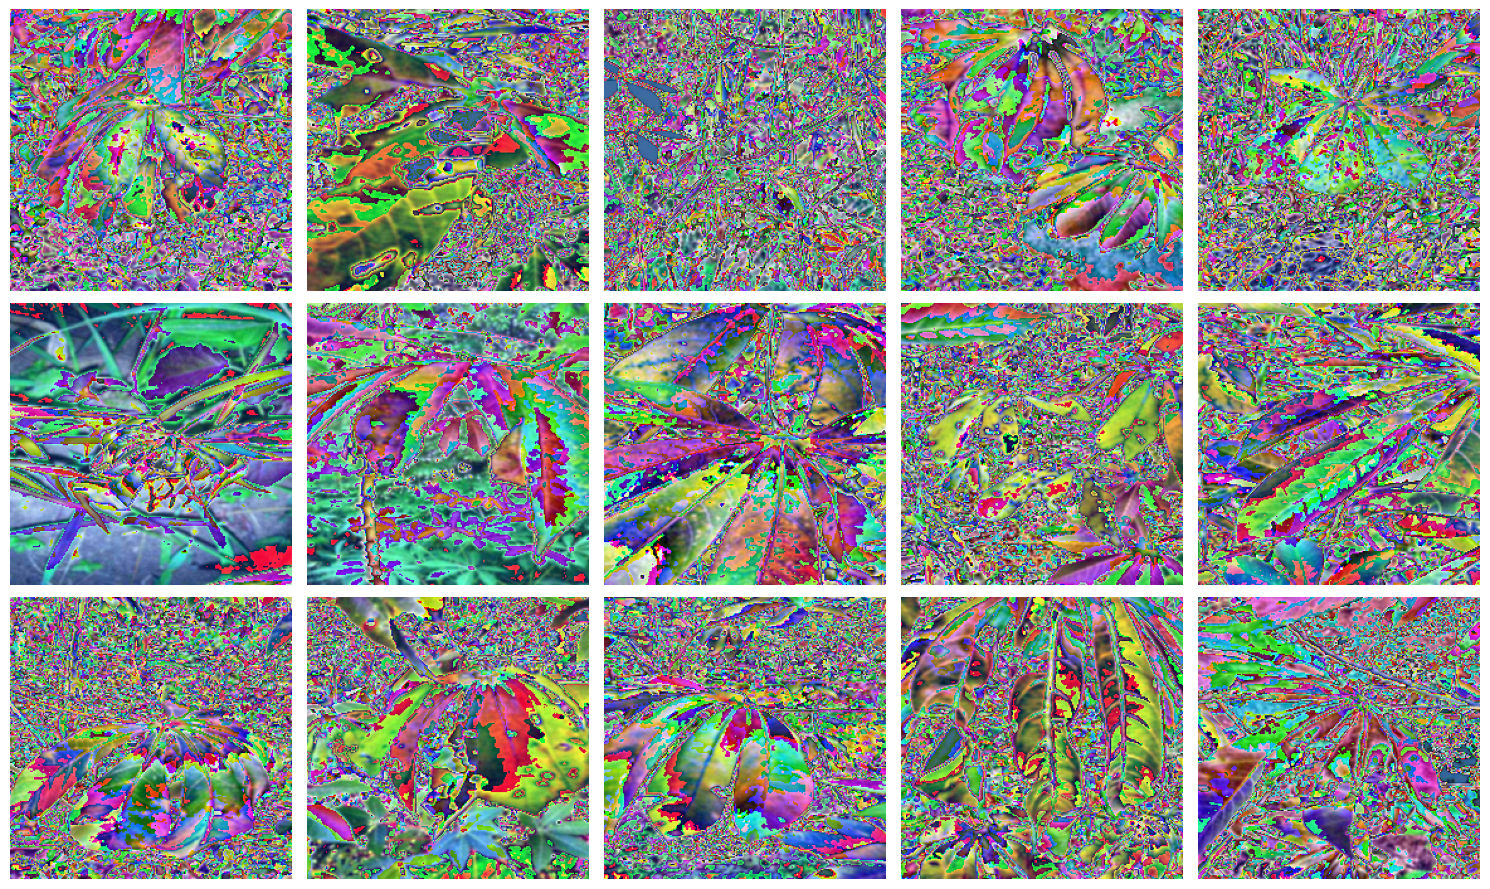

In [9]:
transform = transforms.Compose([
    transforms.Lambda(apply_gaussian_blur),
    transforms.Resize(224),             
    transforms.CenterCrop(224),                 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])
dataset_path = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDisease' 
testing_path = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\test' 
dataset = ImageFolder(root=dataset_path, transform=transform)
test_dataset = ImageFolder(root=testing_path, transform=transform)
def show_images(images, n_rows=3, n_cols=5, figsize=(15, 9)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        img = transforms.functional.to_pil_image(img)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
dataset = ImageFolder(root=dataset_path, transform=transform)
images = [dataset[i][0] for i in range(15,)]
show_images(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


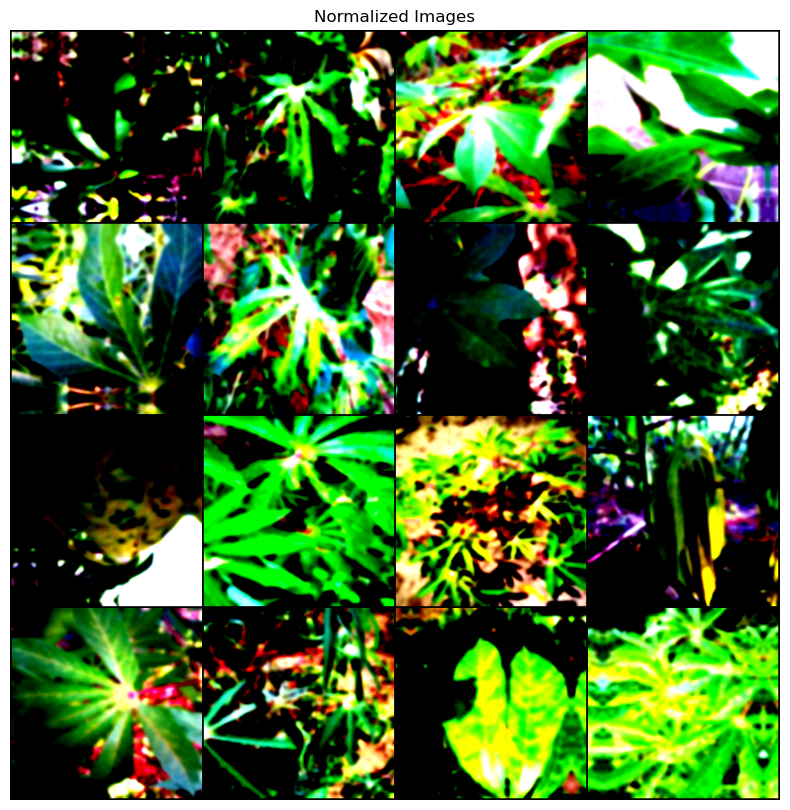

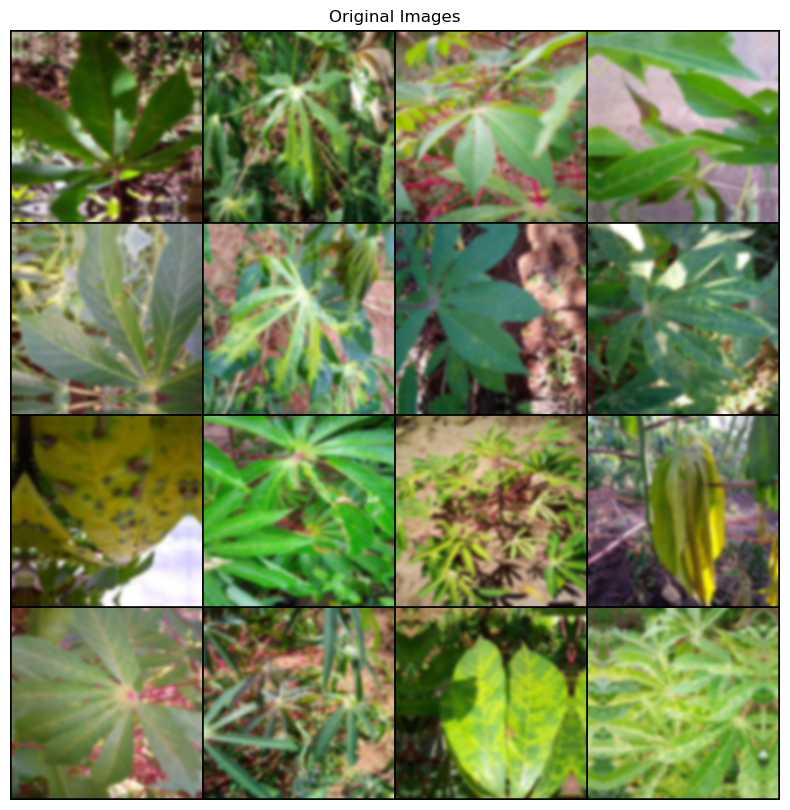

In [3]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(apply_gaussian_blur),
    transforms.ToTensor(),
    normalize
])
dataset_path = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDisease' 
testing_path = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\test' 
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

def plot_images(images, title='Images', nrow=4, inverse=False):
    if inverse:
        images = inv_normalize(images)  
    images = utils.make_grid(images, nrow=nrow)
    np_images = np.transpose(images.numpy(), (1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(np_images)
    plt.title(title)
    plt.axis('off')
    plt.show()

dataiter = iter(dataloader)
images, labels = next(dataiter)

plot_images(images, title='Normalized Images', nrow=4)

plot_images(images, title='Original Images', nrow=4, inverse=True)